### Setup

In [1]:
import pandas as pd
import numpy as np
import ast
import math
import random
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy import stats
import pickle
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
import pickle
from scipy.stats import truncexpon
from dynesty import DynamicNestedSampler

### Function definitions

In [3]:
# copmute invariant masses from a datraframe with the event

Eminbb = 100.0
Eminaa = 120.0
Emaxbb = 140.0
Emaxaa = 130.0
    
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


def expbb(x,a,l):
    return a * np.exp(-l*(x-Eminbb))
    
def expaa(x,a,l):
    return a * np.exp(-l*(x-Eminaa))
    

### Create fake data 

- It is generated with exactly the same PDFs that will be used to extract in the inference process
- We choose parameters such that it is relatively easy to get the contributions in the generated data set


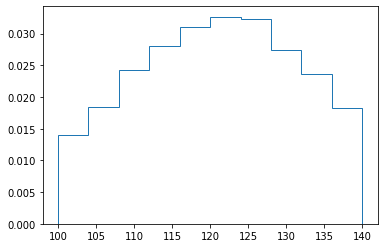

In [4]:
# signal bb
mhbb = 122
shbb = 15
signal_bb = stats.truncnorm.rvs((Eminbb-mhbb)/shbb,(Emaxbb-mhbb)/shbb, loc=mhbb, scale=shbb, size=10000)
plt.hist(signal_bb, histtype='step', density=1)
plt.show()

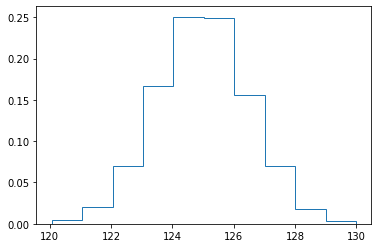

In [5]:
#signal AA
mhaa = 125
shaa = 1.5
signal_aa = stats.truncnorm.rvs((Eminaa-mhaa)/shaa,(Emaxaa-mhaa)/shaa, loc=mhaa, scale=shaa, size=10000)
plt.hist(signal_aa, histtype='step', density=1)
plt.show()

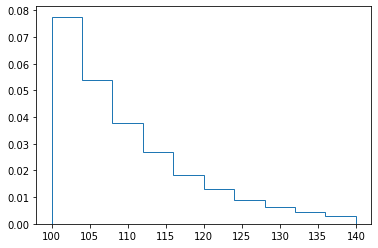

In [6]:
# background bb
expo_start = 100
expo_range = 40
lambda_bb = 0.09
b = expo_range * lambda_bb
background_bb = stats.truncexpon.rvs(b, loc=expo_start, scale=1/lambda_bb, size=100000)
plt.hist(background_bb, histtype='step', density=1)
plt.show()

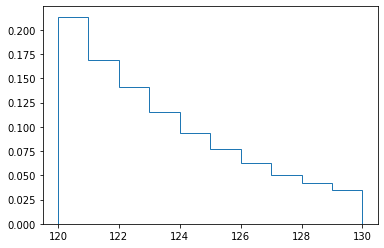

In [7]:
# background AA
expo_start = 120
expo_range = 10
lambda_aa = 0.2
b = expo_range * lambda_aa
background_aa = stats.truncexpon.rvs(b, loc=expo_start, scale=1/lambda_aa, size=100000)
plt.hist(background_aa, histtype='step', density=1)
plt.show()

In [81]:
# We create the lists with the fake data
signal_events = [[signal_bb[i],signal_aa[i],1] for i in range(1000)]
background_events = [[background_bb[i], background_aa[i],0] for i in range(3000)]

## Create a data set with fake data

determine luminosity and signal fraction

In [11]:
def create_data(N, pi_signal):
    Ns = int(N*pi_signal)
    Nb = int(N*(1-pi_signal))
    print(Ns,Nb)
    signal = random.sample(signal_events, Ns)
    signal = [x + [1] for x in signal]
    background = random.sample(background_events, Nb)
    background = [x + [0] for x in background]
    data = signal + background
    random.shuffle(data)    
    return data

300 700


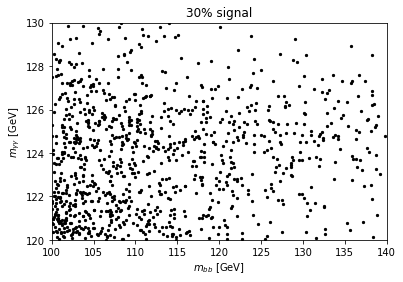

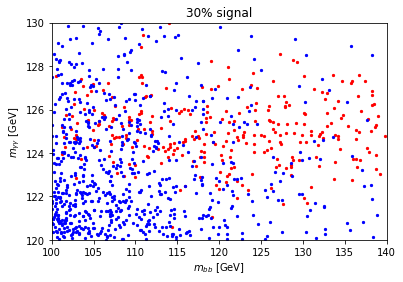

In [12]:
pi_s_true = 0.3
neff = 10000
lendata = 1000
myrun = 'toy-model_dsampler_pi=' + str(pi_s_true) + '_neff=' + str(neff) +'-'+str(lendata)+'-strong-contrast-events'
X = create_data(lendata,pi_s_true)
plt.scatter([x[0] for x in X],[x[1] for x in X],c = 'black',s=5)
plt.xlim(Eminbb,Emaxbb)
plt.ylim(Eminaa,Emaxaa)
plt.xlabel('$m_{bb}$ [GeV]')
plt.ylabel('$m_{\gamma\gamma}$ [GeV]')
plt.title(str(int(pi_s_true*100))+'% signal')
plt.savefig('/home/sequi/Documents/dihiggs/'+myrun+'_unlabeled.png')
plt.show()
plt.scatter([x[0] for x in X if x[2] == 1],[x[1] for x in X if x[2] == 1], s=5, c='red', label='signal')
plt.scatter([x[0] for x in X if x[2] == 0],[x[1] for x in X if x[2] == 0], s=5, c='blue', label='background')
plt.xlim(Eminbb,Emaxbb)
plt.ylim(Eminaa,Emaxaa)
plt.xlabel('$m_{bb}$ [GeV]')
plt.ylabel('$m_{\gamma\gamma}$ [GeV]')
plt.title(str(int(pi_s_true*100))+'% signal')
plt.savefig('/home/sequi/Documents/dihiggs/'+myrun+'_labeled.png')
#plt.legend()
plt.show()

## Dynesty

#### Setup Dynesty

In [13]:
# t is the variables that contains the parameters of the likelihood, t = theta
# t = [muhbb, sigmahbb, muhaa, sigmahaa,  lb, lA, pi_S]
#
def psignaln(x,t,n):
    #return  stats.norm.pdf(x[n][0],t[0], t[1]) * stats.norm.pdf(x[n][1],t[0], t[1])
    return stats.truncnorm.pdf(x[n][0], (Eminbb-t[0])/t[1],(Emaxbb-t[0])/t[1], loc=t[0], scale=t[1]) * stats.truncnorm.pdf(x[n][1], (Eminaa-t[2])/t[3],(Emaxaa-t[2])/t[3], loc=t[2], scale=t[3])

def pbackgroundn(x,t,n):
    return ( t[4] * np.exp(- t[4] * (x[n][0] - Eminbb) ) / (1 - np.exp(- t[4] * (Emaxbb - Eminbb))) ) * ( t[5] * np.exp(- t[5] * (x[n][1] - Eminaa) ) / (1 - np.exp(- t[5] * (Emaxaa - Eminaa))) )
    
def pn(x,t,n):
    return ( 1 - t[6] ) * pbackgroundn(x,t,n) + ( t[6] ) * psignaln(x,t,n)

def lnp(x,t):
    return sum ( [ np.log(pn(x,t,n)) for n in range(len(x)) ] )

# This is a function of just t.  X should be a global variable (list) containing in each element
# the [mbb, maa] of event.
def loglike(t):
    return lnp(X,t)

#### Prior: it should be biased from the true value

In [18]:
popt_bb  = [0, mhbb, shbb]
popt_aa = [0, mhaa, shaa]
popt_bb_background = [0, lambda_bb]
popt_aa_background = [0, lambda_aa]

In [19]:
popt_bb_biased = [0, mhbb*1.08, shbb*1.10]
popt_aa_biased = [0, mhaa*0.99, shaa*0.90]
popt_bb_background_biased = [0, lambda_bb*1.4]
popt_aa_background_biased = [0, lambda_aa*0.75]
popt_bb_biased, popt_aa_biased, popt_bb_background_biased, popt_aa_background_biased

([0, 131.76000000000002, 16.5],
 [0, 123.75, 1.35],
 [0, 0.126],
 [0, 0.15000000000000002])

In [21]:
# Define the prior
alpha = 1
beta = 1
# Define our uniform prior.
def ptform(u):
    x = np.array(u)  # copy u
    x[0] = stats.norm.ppf(u[0], popt_bb_biased[1], popt_bb_biased[1]*0.15) # Mean for mbb center: A Normal with its center biased and a deviation equal to 5% of the mean
    x[1] = stats.norm.ppf(u[1], popt_bb_biased[2], popt_bb_biased[2]*0.15) # Sigma or mbb
    x[2] = stats.norm.ppf(u[2], popt_aa_biased[1], popt_aa_biased[1]*0.10) # Mean for mAA
    x[3] = stats.norm.ppf(u[3], popt_aa_biased[2], popt_aa_biased[2]*0.15) # Sigma for mAA   
    x[4] = stats.norm.ppf(u[4], popt_bb_background_biased[1], popt_bb_background_biased[1]*0.40) # lambda for bb
    x[5] = stats.norm.ppf(u[5], popt_aa_background_biased[1], popt_aa_background_biased[1]*0.40) # lambda for AA    
    x[6] = stats.beta.ppf(u[6], alpha, beta) # signal fraction
#    x[6] = 1 - u[6]
    return x
ndim = 7

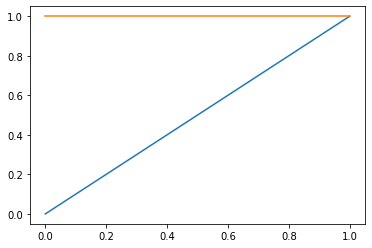

In [22]:
plt.plot(np.linspace(0,1,100),[stats.beta.ppf(x,alpha, beta) for x in np.linspace(0,1,100)])
plt.plot(np.linspace(0,1,100),[stats.beta.pdf(x,alpha, beta) for x in np.linspace(0,1,100)])
plt.show()

### Sampling

In [23]:
%%time
dsampler = DynamicNestedSampler(loglike, ptform, ndim)
dsampler.run_nested(dlogz_init=0.05, nlive_init=500, maxiter_init=5000, nlive_batch=50, n_effective=neff, maxbatch=100)

15612it [20:21:33,  4.69s/it, batch: 36 | bound: 73 | nc: 3 | ncall: 282715 | eff(%):  5.522 | loglstar: -5662.404 < -5654.790 < -5656.349 | logz: -5669.080 +/-  0.124 | stop:  0.984]   

CPU times: user 20h 24min 27s, sys: 19min 47s, total: 20h 44min 14s
Wall time: 20h 21min 33s


In [45]:
xtrue = [popt_bb[1], popt_bb[2], popt_aa[1], popt_aa[2], popt_bb_background[1], popt_aa_background[1], pi_s_true]

In [46]:
xtrue_biased = [popt_bb_biased[1], popt_bb_biased[2], popt_aa_biased[1], popt_aa_biased[2], popt_bb_background_biased[1], popt_aa_background_biased[1], pi_s_true]

In [27]:
results = dsampler.results

/home/sequi/.local/lib/python3.8/site-packages/dynesty/plotting_sequi2.py:315: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


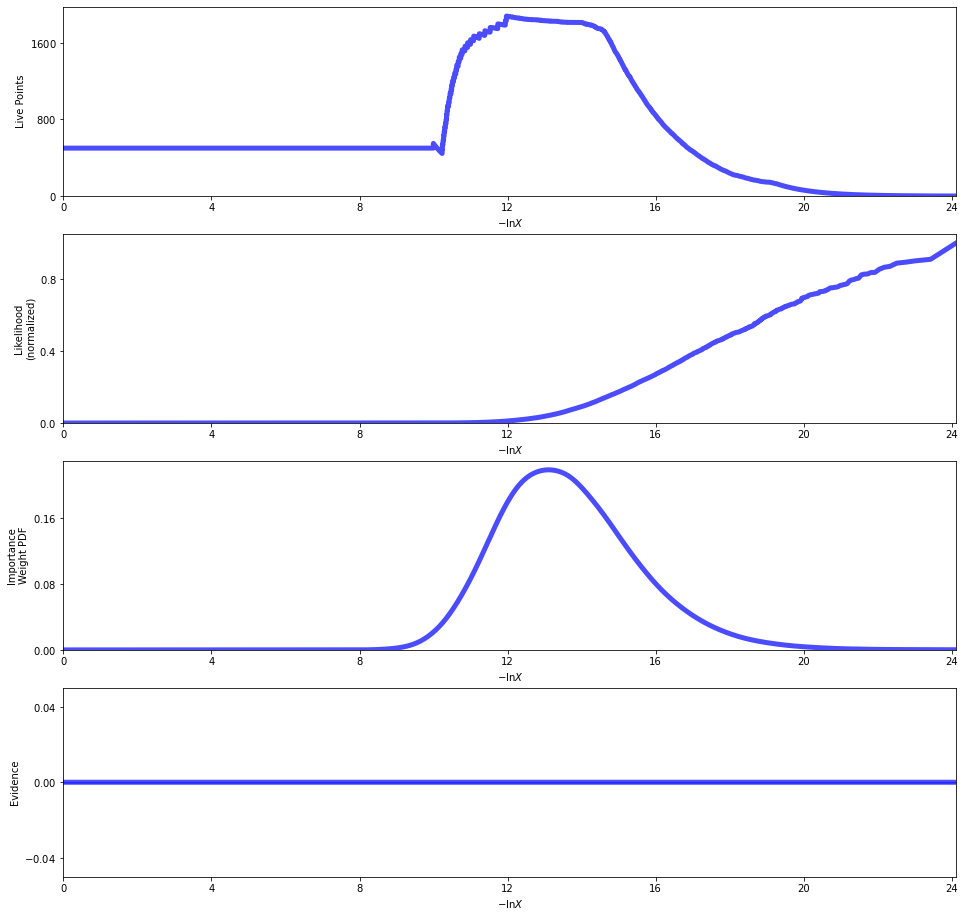

In [80]:
fig, axes = dyplot.runplot(results)
#tfig, taxes = dyplot.traceplot(results, truths=xtrue_biased,quantiles=None, labels=['$\mu_{bb}$','$\sigma_{bb}$','$\mu_{\gamma\gamma}$','$\sigma_{\gamma\gamma}$','$\lambda_b$','$lambda_\gamma$', '$\pi_S$'])
#tfig2, taxes2 = dyplot.traceplot(results, truths=xtrue,quantiles=None, labels=['$\mu_{bb}$','$\sigma_{bb}$','$\mu_{\gamma\gamma}$','$\sigma_{\gamma\gamma}$','$\lambda_b$','$lambda_\gamma$', '$\pi_S$'])

In [85]:
myresults = {'X': X, 'xtrue': xtrue, 'xtrue_biased': xtrue_biased}

In [86]:
myrun

'toy-model_dsampler_pi=0.3_neff=10000-1000-strong-contrast-events'

In [87]:
with open('/home/sequi/Documents/dihiggs/'+myrun+'_results.pkl', 'wb') as f:
    pickle.dump(results, f)
    
with open('/home/sequi/Documents/dihiggs/'+myrun+'_my_results.pkl', 'wb') as f:
    pickle.dump(myresults, f)

In [88]:
from dynesty import plotting_sequi2 as dyplot

In [89]:
means = [[myresults['xtrue_biased'][0],0.15*myresults['xtrue_biased'][0]], 
         [myresults['xtrue_biased'][1],0.15*myresults['xtrue_biased'][1]], 
         [myresults['xtrue_biased'][2],0.10*myresults['xtrue_biased'][2]], 
         [myresults['xtrue_biased'][3],0.15*myresults['xtrue_biased'][3]], 
         [myresults['xtrue_biased'][4],0.40*myresults['xtrue_biased'][4]], 
         [myresults['xtrue_biased'][5],0.40*myresults['xtrue_biased'][5]], 
         [0.5,0.5]]

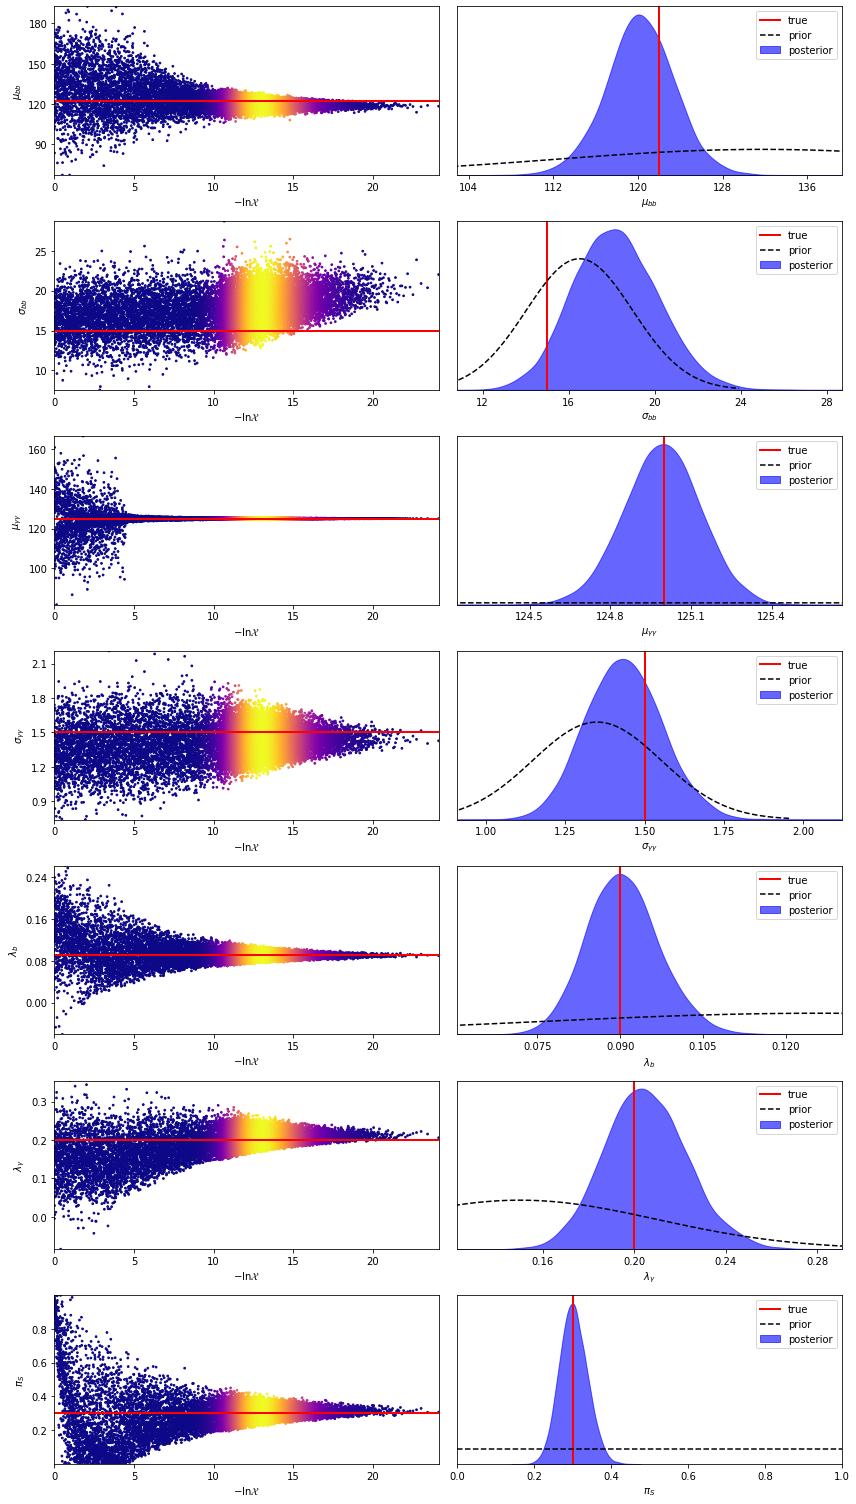

In [90]:
tfig2, taxes2 = dyplot.traceplot(results, post_color='blue', truths=myresults['xtrue'], means= means, quantiles=None, labels=['$\mu_{bb}$','$\sigma_{bb}$','$\mu_{\gamma\gamma}$','$\sigma_{\gamma\gamma}$','$\lambda_b$','$\lambda_\gamma$', '$\pi_S$'])

In [93]:
# slight view corrections to have better plots
taxes2[0][1].set_xlim(100,160)
taxes2[2][1].set_xlim(123-36,123+36)
taxes2[2][1].set_ylim(0,.1)
taxes2[4][1].set_xlim(means[4][0]-2*means[4][1],means[4][0]+2*means[4][1])
taxes2[4][1].set_ylim(0,20)
taxes2[5][1].set_xlim(means[5][0]-2*means[5][1],means[5][0]+2*means[5][1])
taxes2[6][1].set_xlim(0,1)

(0.0, 1.0)

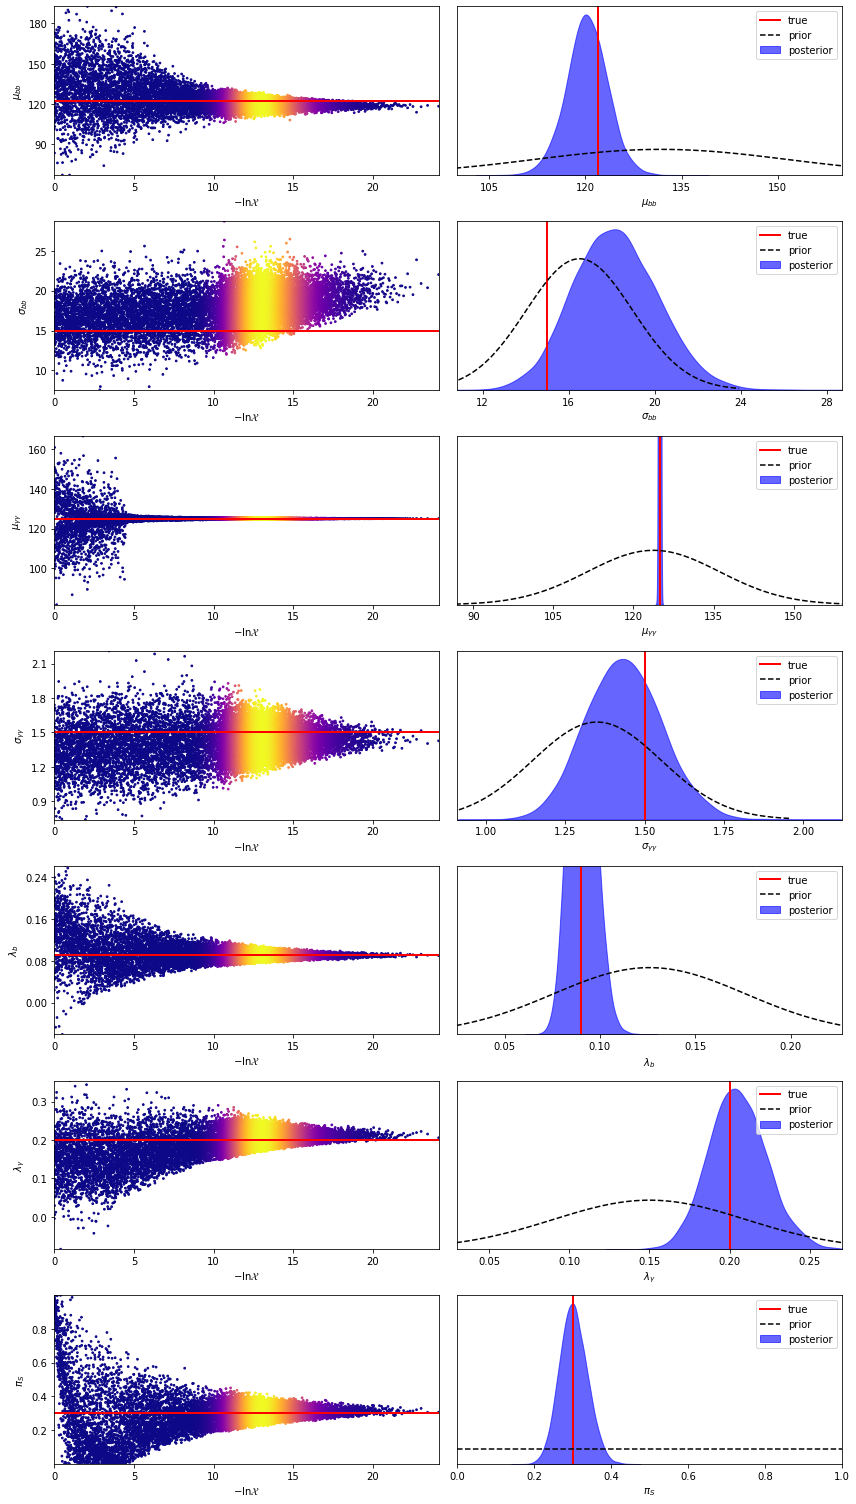

In [94]:
tfig2

In [95]:
tfig2.savefig(myrun+'.jpg')